<h1 align=center><font size = 5>Segmenting and Clustering Indian Restaurants in New York City</font></h1>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [239]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\amist\miniconda3

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       he774522_0         5.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.7 MB

The following packages will be UPDATED:

  conda                       pkgs/main::conda-4.8.3-py37_0 --> conda-forge::conda-4.8.3-py37hc8dfbb8_1

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2020.6.24-0 --> conda-forge::ca-certificates-2020.6.20-hecda079_0
  certifi               pkgs/main::certifi-2020.6.20-py37_0 --> conda-forge::certifi-2020.6.20-py37hc8dfbb8_0
  openssl                                     

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename C:\Users\amist\miniconda3\pkgs\openssl-1.1.1g-he774522_0.tar.bz2.  Please remove this file manually (you may need to reboot to free file handles)

InvalidArchiveError('Error with archive C:\\Users\\amist\\miniconda3\\pkgs\\openssl-1.1.1g-he774522_0.tar.bz2.  You probably need to delete and re-download or re-create this file.  Message from libarchive was:\n\nCould not unlink')



In [240]:
!pip install -U scikit-learn scipy matplotlib
from sklearn.cluster import DBSCAN 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Requirement already up-to-date: scikit-learn in c:\users\amist\miniconda3\lib\site-packages (0.23.1)
Requirement already up-to-date: scipy in c:\users\amist\miniconda3\lib\site-packages (1.5.2)
Requirement already up-to-date: matplotlib in c:\users\amist\miniconda3\lib\site-packages (3.3.0)
Libraries imported.


<a id='item1'></a>

## 1. Download and NYC neighbourhood Dataset

In [241]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

In [242]:
with open(r'C:\Users\amist\Downloads/nyu_2451_34572-geojson_main.json') as json_data:
    newyork_data = json.load(json_data)
    newyork_data

Information we need is in features

In [243]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a *pandas* dataframe

In [244]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [245]:
neighborhoods

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

Then let's loop through the data and fill the dataframe one row at a time.

In [246]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [247]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

Check that the dataset has all 5 boroughs and 306 neighborhoods.

In [248]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [249]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Define Foursquare Credentials and Version

<a id='item2'></a>

In [250]:
categoryId='4bf58dd8d48988d10f941735'

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT,
    categoryId)

#### Let's get data on all Indian restaurants in NYC

In [251]:
def getNearbyVenues(names, latitudes, longitudes, radius=750,categoryId='4bf58dd8d48988d10f941735'):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now check each neighborhood and create a new dataframe called *nyc_venues*.

In [254]:
# type your answer here

nyc_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )



Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [256]:
nyc_venues.shape

(938, 7)

#### Clean the data and remove duplicates

In [257]:
Indian_restaurants=nyc_venues[nyc_venues['Venue Category'].str.contains("India",case=False,na=False)]
Indian_restaurants.drop_duplicates(subset=["Venue Latitude","Venue Longitude","Venue"], keep='first', inplace=True)

Indian_restaurants.sort_values(by=["Neighborhood"],inplace=True)
Indian_restaurants.head(30)
#test.head(20)

C:\Users\amist\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\amist\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
540            Astoria              40.768509              -73.915654   
541            Astoria              40.768509              -73.915654   
542            Astoria              40.768509              -73.915654   
543            Astoria              40.768509              -73.915654   
544            Astoria              40.768509              -73.915654   
545            Astoria              40.768509              -73.915654   
546            Astoria              40.768509              -73.915654   
101         Bath Beach              40.599519              -73.998752   
511  Battery Park City              40.711932              -74.016869   
514  Battery Park City              40.711932              -74.016869   
512  Battery Park City              40.711932              -74.016869   
517  Battery Park City              40.711932              -74.016869   
515  Battery Park City              40.711932              -74.016869   
516  Battery Park City              40.711932              -74.016869   
508  Battery Park City              40.711932              -74.016869   
509  Battery Park City              40.711932              -74.016869   
510  Battery Park City              40.711932              -74.016869   
36           Bay Ridge              40.625801              -74.030621   
37           Bay Ridge              40.625801              -74.030621   
617            Bayside              40.766041              -73.774274   
616            Bayside              40.766041              -73.774274   
615            Bayside              40.766041              -73.774274   
614            Bayside              40.766041              -73.774274   
613            Bayside              40.766041              -73.774274   
612            Bayside              40.766041              -73.774274   
933          Bayswater              40.611322              -73.765968   
671           Bellaire              40.733014              -73.738892   
622          Bellerose              40.728573              -73.720128   
623          Bellerose              40.728573              -73.720128   
114        Boerum Hill              40.685683              -73.983748   

                              Venue  Venue Latitude  Venue Longitude  \
540             Seva Indian Cuisine       40.765521       -73.919157   
541                       The Gully       40.766719       -73.912410   
542              Tikka Indian Grill       40.765397       -73.918658   
543                         Namaste       40.766669       -73.920784   
544                   Kurry Qulture       40.764978       -73.917151   
545                Tikka Roll House       40.765400       -73.918702   
546                 Taste of Bengal       40.767854       -73.920663   
101                   India’s Curry       40.602152       -74.003124   
511            Biryani House (Cart)       40.708081       -74.010431   
514                    Bangal Curry       40.713550       -74.009096   
512                   Diwan-E-Khaas       40.708967       -74.009013   
517            smart indian cuisine       40.709022       -74.009117   
515  Indian Biryani Delights (Cart)       40.713165       -74.010219   
516                  Indian Express       40.713413       -74.008469   
508            Ruchi Indian Cuisine       40.709962       -74.012969   
509                         Benares       40.714117       -74.009248   
510           The Kati Roll Company       40.709114       -74.009091   
36                     Bombay Grill       40.622371       -74.031799   
37                  King of Tandoor       40.631832       -74.027361   
617                          masala       40.762555       -73.770476   
616                      Masala Box       40.762470       -73.770668   
615             Agra Indian Cuisine       40.765396       -73.771535   
614                       masalabox       40.762670       -73.770690   
613               

## Create a map showing the distribution of Indian restaurants(blue) and the neighbourhood locations(red)

In [258]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
       # add the Indian restaurants as blue circle markers
for lat, lng in zip(Indian_restaurants['Venue Latitude'], Indian_restaurants['Venue Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup='Indian Rest',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_newyork)
    

map_newyork

<a id='item3'></a>

### Let's check how many venues were returned for each neighborhood, remove additional Columns and gett the frequency count per neighborhood

In [281]:
Indian_restaurants_grouped=Indian_restaurants.groupby('Neighborhood').count()
Indian_restaurants_grouped.drop(["Neighborhood Latitude","Neighborhood Longitude", "Venue","Venue Latitude","Venue Longitude"], axis=1, inplace=True)
Indian_restaurants_grouped.rename(columns={'Venue Category':'Frequency'}, inplace=True)
Indian_restaurants_grouped.head()


Frequency
Neighborhood                
Astoria                    7
Bath Beach                 1
Battery Park City          9
Bay Ridge                  2
Bayside                    6

### Plot a bar chart showing the frequency for each neighborhood

Matplotlib version:  3.3.0
[80 19 10  2  1  2  3  1  0  1]
[ 1.   3.9  6.8  9.7 12.6 15.5 18.4 21.3 24.2 27.1 30. ]


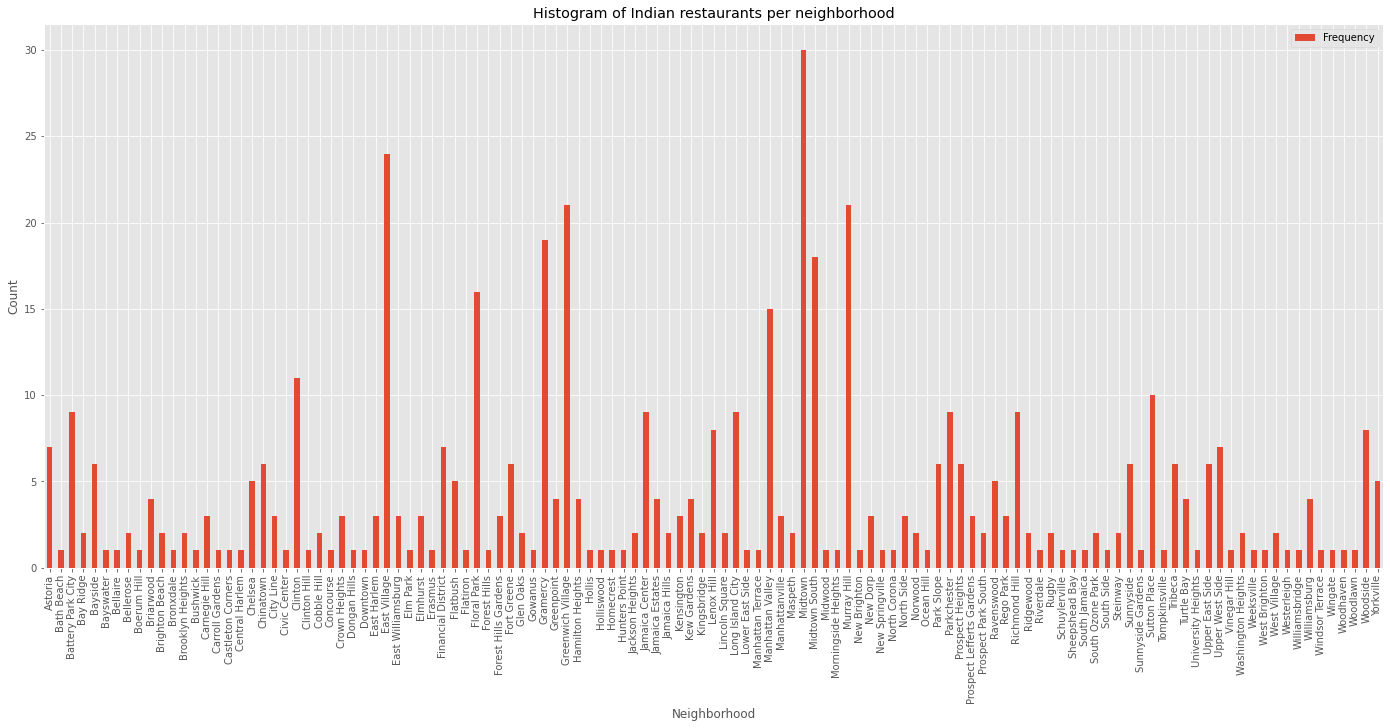

In [282]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# np.histogram returns 2 values
count, bin_edges = np.histogram(Indian_restaurants_grouped)

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins
Indian_restaurants_grouped.plot(kind='bar', figsize=(24, 10))

plt.title('Histogram of Indian restaurants per neighborhood') # add a title to the histogram
plt.ylabel('Count') # add y-label
plt.xlabel('Neighborhood') # add x-label

plt.show()


Midtown, East village, Greenwich Village and Murray Hill all have more than twenty Indian restaurants in them

Resetting index for the next steps

In [283]:
Indian_restaurants_grouped.reset_index(level=0, inplace=True)
Indian_restaurants_grouped.head()

Neighborhood  Frequency
0            Astoria          7
1         Bath Beach          1
2  Battery Park City          9
3          Bay Ridge          2
4            Bayside          6

### Load a json file which has the polygons for each neighbourhood (from https://maps.princeton.edu/catalog/nyu-2451-34561)

In [284]:
with open(r'C:\Users\amist\Downloads/nyu-2451-34561-geojson.json') as json_data2:
    newyork_areas = json.load(json_data2)
    newyork_areas


### Create a chloropleth map showing the distribution of Indian restaurants across different neighborhoods in the city

In [285]:
# create map of New York using latitude and longitude values
map_newyork_chloro =folium.Map(location=[latitude, longitude], zoom_start=10)

map_newyork_chloro.choropleth(
    geo_data=newyork_areas,
    data=Indian_restaurants_grouped,
    columns=['Neighborhood', 'Frequency'],
    key_on='feature.properties.ntaname',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Twat'
)

# display map
map_newyork_chloro


In [286]:
Indian_restaurants_grouped.head()

Neighborhood  Frequency
0            Astoria          7
1         Bath Beach          1
2  Battery Park City          9
3          Bay Ridge          2
4            Bayside          6

## 4. Cluster Neighborhoods

Drop the Neighbourhood Column

In [287]:
Indian_restaurants_grouped_k=Indian_restaurants_grouped.drop('Neighborhood',axis=1)
Indian_restaurants_grouped_k.head()

Frequency
0          7
1          1
2          9
3          2
4          6

<a id='item4'></a>

Run *k*-means to cluster the neighborhood into 5 clusters.

In [288]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Indian_restaurants_grouped_k)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 3, 0, 2, 0, 0, 0, 0, 5])

Let's create a new dataframe that includes all of the information

In [289]:
Indian_restaurants_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [290]:

Indian_restaurants_all=pd.merge(Indian_restaurants_grouped, Indian_restaurants, on='Neighborhood')
Indian_restaurants_all.head()


Cluster Labels Neighborhood  Frequency  Neighborhood Latitude  \
0               2      Astoria          7              40.768509   
1               2      Astoria          7              40.768509   
2               2      Astoria          7              40.768509   
3               2      Astoria          7              40.768509   
4               2      Astoria          7              40.768509   

   Neighborhood Longitude                Venue  Venue Latitude  \
0              -73.915654  Seva Indian Cuisine       40.765521   
1              -73.915654            The Gully       40.766719   
2              -73.915654   Tikka Indian Grill       40.765397   
3              -73.915654              Namaste       40.766669   
4              -73.915654        Kurry Qulture       40.764978   

   Venue Longitude     Venue Category  
0       -73.919157  Indian Restaurant  
1       -73.912410  Indian Restaurant  
2       -73.918658  Indian Restaurant  
3       -73.920784  Indian Restaurant  
4       -73.917151  Indian Restaurant

Finally, let's visualize the resulting clusters

In [291]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Indian_restaurants_all['Venue Latitude'], Indian_restaurants_all['Venue Longitude'], Indian_restaurants_all['Neighborhood'], Indian_restaurants_all['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

Purple shows a high density of nearby restarants whereas red is sparse

## Use dBScan for clustering information

In [273]:
Indian_restaurants_all.head()

Cluster Labels Neighborhood  Frequency  Neighborhood Latitude  \
0               4      Astoria          7              40.768509   
1               4      Astoria          7              40.768509   
2               4      Astoria          7              40.768509   
3               4      Astoria          7              40.768509   
4               4      Astoria          7              40.768509   

   Neighborhood Longitude                Venue  Venue Latitude  \
0              -73.915654  Seva Indian Cuisine       40.765521   
1              -73.915654            The Gully       40.766719   
2              -73.915654   Tikka Indian Grill       40.765397   
3              -73.915654              Namaste       40.766669   
4              -73.915654        Kurry Qulture       40.764978   

   Venue Longitude     Venue Category  
0       -73.919157  Indian Restaurant  
1       -73.912410  Indian Restaurant  
2       -73.918658  Indian Restaurant  
3       -73.920784  Indian Restaurant  
4       -73.917151  Indian Restaurant

In [274]:
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = Indian_restaurants_all[['Venue Latitude','Venue Longitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)
min_samples=4
# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=4).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
Indian_restaurants_all["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
Indian_restaurants_all[["Neighborhood","Clus_Db"]].head(5)
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

### Plot the clusters on a map

In [275]:
# create map
map_dbScan = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(10)
ys = [i + x + (i*x)**2 for i in range(10)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, labels in zip(Indian_restaurants_all['Venue Latitude'], Indian_restaurants_all['Venue Longitude'], Indian_restaurants_all['Venue'], Indian_restaurants_all['Clus_Db']):
    label = folium.Popup(str(poi) + ' DbCluster ' + str(label), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[labels-1],
        fill=True,
        fill_color=rainbow[labels-1],
        fill_opacity=0.7).add_to(map_dbScan)
       
map_dbScan

Manhatten clearly has a high density of nearby restaurants (purple) while some regions outside also have some clusters with orange being outliers